# Pasos previos
## Listado de software y hardware utilizados

In [2]:
%load_ext watermark
%watermark -a "Rodrigo Galdeano" -nmv --packages numpy,pandas,sklearn,matplotlib,surprise,missingno

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Rodrigo Galdeano Wed Dec 04 2019 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
pandas 0.25.0
sklearn 0.20.3
matplotlib 3.0.3
surprise 1.0.6
missingno 0.4.2

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


## Imports e inicialización de directorio (TODO: cambiar a dir relativo)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import missingno as msno
from surprise import SVD, CoClustering, Dataset, Reader
from surprise.model_selection import cross_validate, KFold
from collections import defaultdict, Counter

#os.chdir("C:/Users/Rod/Dropbox/universidad/tesis/src")

# Compresión de los datos
## Users
Primero cargamos los datos tomados para los objetos Users y quitamos algunas claves extras del json para visualizar mejor los datos

In [4]:
user_data = []

for i in (10,50,100,1000,5000):
    with open("user_data_" + str(i) +".json") as user_data_file:
        user_data_file_raw = json.load(user_data_file)['data']['search']['edges']
        
    user_data_file_no_initial_nodes = []
    
    for i, j in enumerate(user_data_file_raw):
        user_data_file_no_initial_nodes.append(user_data_file_raw[i]['node'])
        user_data_file_no_initial_nodes[-1]['repositories'] = user_data_file_no_initial_nodes[-1]['repositories']['edges']
        user_data_file_no_initial_nodes[-1]['starredRepositories'] = user_data_file_no_initial_nodes[-1]['starredRepositories']['edges']
        user_data_file_no_initial_nodes[-1]['followers'] = user_data_file_no_initial_nodes[-1]['followers']['edges']
        user_data_file_no_initial_nodes[-1]['following'] = user_data_file_no_initial_nodes[-1]['following']['edges']

        for i,j in enumerate(user_data_file_no_initial_nodes[-1]['repositories']):
            user_data_file_no_initial_nodes[-1]['repositories'][i] = j['node']
        for i,j in enumerate(user_data_file_no_initial_nodes[-1]['starredRepositories']):
            user_data_file_no_initial_nodes[-1]['starredRepositories'][i] = j['node']
        for i,j in enumerate(user_data_file_no_initial_nodes[-1]['followers']):
            user_data_file_no_initial_nodes[-1]['followers'][i] = j['node']   
        for i,j in enumerate(user_data_file_no_initial_nodes[-1]['following']):
            user_data_file_no_initial_nodes[-1]['following'][i] = j['node']

    user_data += user_data_file_no_initial_nodes

Pasamos el json a una tabla de pandas

In [5]:
df_users_original = pd.io.json.json_normalize(user_data)
df_users_original.head()

,login,location,repositories,starredRepositories,followers,following
0,NivedithaVNair,None,"[{'name': 'welcome', 'owner': {'login': '77rak...","[{'name': 'testproject', 'owner': {'login': 'm...","[{'login': 'Annmariya123'}, {'login': 'annmg'}...","[{'login': '98MARIYA'}, {'login': 'MALAVIKA199..."
1,frodio,None,[],"[{'name': 'mojo', 'owner': {'login': 'mojolici...","[{'login': 'janvajda'}, {'login': 'Alive-Attem...","[{'login': 'sharifulin'}, {'login': 'kraih'}, ..."
2,sbange,Germany,"[{'name': 're', 'owner': {'login': 'ahx'}}, {'...","[{'name': 'node-v0.x-archive', 'owner': {'logi...","[{'login': 'jonas-koeritz'}, {'login': 'dennis...","[{'login': 'wulfovitch'}, {'login': 'achimgrim..."
3,imperio,None,"[{'name': 'str', 'owner': {'login': 'imperio'}...","[{'name': 'nu', 'owner': {'login': 'nulang'}},...","[{'login': 'akozlu'}, {'login': 'golddiamonds'...","[{'login': 'cemurat'}, {'login': 'megatony'}, ..."
4,david-schneider-editor,None,"[{'name': 'Arduino-Robosub', 'owner': {'login'...","[{'name': 'Arduino-Robosub', 'owner': {'login'...","[{'login': 'mitoksim'}, {'login': 'piqueen314'...",[]


Cargamos el json y creamos la tabla de algunos datos adicionales numericos sobre Users

In [6]:
with open("users_additional_data.txt") as user_add_data_file:
    user_add_data_file_raw = json.load(user_add_data_file)

df_users_additonal = pd.io.json.json_normalize(user_add_data_file_raw, sep='_')
df_users_additonal.rename(lambda x: x[10:] if 'data' in x else x, axis=1, inplace=True)
df_users_additonal.head()

,login,repositories_totalCount,starredRepositories_totalCount,followers_totalCount,following_totalCount
0,NivedithaVNair,6,1,10,10
1,frodio,0,5,10,3
2,sbange,5,54,10,16
3,imperio,10,5,10,9
4,david-schneider-editor,6,1,10,0


Hacemos el merge de ambas tablas en una tabla de users definitiva

In [7]:
df_users = pd.merge(df_users_original, df_users_additonal, on='login')
df_users.head()

,login,location,repositories,starredRepositories,followers,following,repositories_totalCount,starredRepositories_totalCount,followers_totalCount,following_totalCount
0,NivedithaVNair,None,"[{'name': 'welcome', 'owner': {'login': '77rak...","[{'name': 'testproject', 'owner': {'login': 'm...","[{'login': 'Annmariya123'}, {'login': 'annmg'}...","[{'login': '98MARIYA'}, {'login': 'MALAVIKA199...",6,1,10,10
1,frodio,None,[],"[{'name': 'mojo', 'owner': {'login': 'mojolici...","[{'login': 'janvajda'}, {'login': 'Alive-Attem...","[{'login': 'sharifulin'}, {'login': 'kraih'}, ...",0,5,10,3
2,sbange,Germany,"[{'name': 're', 'owner': {'login': 'ahx'}}, {'...","[{'name': 'node-v0.x-archive', 'owner': {'logi...","[{'login': 'jonas-koeritz'}, {'login': 'dennis...","[{'login': 'wulfovitch'}, {'login': 'achimgrim...",5,54,10,16
3,imperio,None,"[{'name': 'str', 'owner': {'login': 'imperio'}...","[{'name': 'nu', 'owner': {'login': 'nulang'}},...","[{'login': 'akozlu'}, {'login': 'golddiamonds'...","[{'login': 'cemurat'}, {'login': 'megatony'}, ...",10,5,10,9
4,david-schneider-editor,None,"[{'name': 'Arduino-Robosub', 'owner': {'login'...","[{'name': 'Arduino-Robosub', 'owner': {'login'...","[{'login': 'mitoksim'}, {'login': 'piqueen314'...",[],6,1,10,0


## Repositorios
Cargamos los datos tomados para los objetos repositorios

In [8]:
repo_data = []
repo_paths = ['repositories', 'starredRepositories']

for user_counter,user in enumerate(user_data):
    for path in repo_paths:
        repo_counter = 0
        while True:
            try:
                with open("repos/" + str(user_counter) +"/" + path + "/" + str(repo_counter) + ".json") as repo_data_file:
                    repo_data_file_raw = json.load(repo_data_file)
                    repo_data.append(repo_data_file_raw['data'])
                repo_counter += 1
            except:
                break

Pasamos el json a una tabla de pandas

In [9]:
repo_data = [x for x in repo_data if x]
df_repos = pd.io.json.json_normalize(repo_data, sep="_")
df_repos.tail()

,repository_name,repository_owner_login,repository_isFork,repository_createdAt,repository_parent,repository_isLocked,repository_isPrivate,repository_isArchived,repository_isDisabled,repository_forks_totalCount,...,repository_languages_edges,repository_stargazers_totalCount,repository_stargazers_edges,repository_repositoryTopics_edges,repository_issues_totalCount,repository_issues_edges,repository_parent_name,repository_parent_owner_login,repository_primaryLanguage_name,repository
11222,scikit-learn-doc-zh,apachecn,False,2017-09-27T03:25:03Z,NaN,False,False,False,False,751.0,...,"[{'node': {'name': 'HTML'}}, {'node': {'name':...",2340.0,"[{'node': {'login': 'chenyyx'}}, {'node': {'lo...","[{'node': {'topic': {'name': 'python', 'relate...",23.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,HTML,NaN
11223,Screenshot-to-code,emilwallner,False,2017-10-16T11:41:48Z,NaN,False,False,False,False,1111.0,...,"[{'node': {'name': 'Jupyter Notebook'}}, {'nod...",11737.0,"[{'node': {'login': 'emilwallner'}}, {'node': ...","[{'node': {'topic': {'name': 'keras', 'related...",34.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,HTML,NaN
11224,HanTTS,junzew,False,2017-06-04T20:02:36Z,NaN,False,False,False,False,41.0,...,"[{'node': {'name': 'Python'}}, {'node': {'name...",118.0,"[{'node': {'login': 'superhg2012'}}, {'node': ...","[{'node': {'topic': {'name': 'text-to-speech',...",5.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,Python,NaN
11225,django-bruteforce-protection,orsinium,False,2018-03-01T11:52:18Z,NaN,False,False,False,False,2.0,...,"[{'node': {'name': 'Python'}}, {'node': {'name...",104.0,"[{'node': {'login': 'TC406'}}, {'node': {'logi...","[{'node': {'topic': {'name': 'django', 'relate...",1.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,Python,NaN
11226,NTU-HsuanTienLin-MachineLearning,RedstoneWill,False,2018-05-05T05:42:53Z,NaN,False,False,False,False,525.0,...,[],1407.0,"[{'node': {'login': 'WangYang-wy'}}, {'node': ...",[{'node': {'topic': {'name': 'machine-learning...,2.0,"[{'node': {'state': 'OPEN', 'closed': False, '...",NaN,NaN,NaN,NaN


Quitamos columnas que pandas no deberia haber tomado, porque el contenido esta en otras columnas y estas se encuentran vacias

In [10]:
df_repos.drop(['repository', 'repository_parent', 'repository_primaryLanguage',], axis=1, inplace=True)

Renombramos las columnas para mayor legibilidad

In [11]:
df_repos.rename(lambda x: x[11:] if "repository" in x else x, axis=1, inplace=True)
df_repos.rename(lambda x: x[:-6] if "edges" in x else x, axis=1, inplace=True)
df_repos.tail()

,name,owner_login,isFork,createdAt,isLocked,isPrivate,isArchived,isDisabled,forks_totalCount,forks,languages,stargazers_totalCount,stargazers,repositoryTopics,issues_totalCount,issues,parent_name,parent_owner_login,primaryLanguage_name
11222,scikit-learn-doc-zh,apachecn,False,2017-09-27T03:25:03Z,False,False,False,False,751.0,"[{'node': {'name': 'scikit-learn-doc-zh', 'url...","[{'node': {'name': 'HTML'}}, {'node': {'name':...",2340.0,"[{'node': {'login': 'chenyyx'}}, {'node': {'lo...","[{'node': {'topic': {'name': 'python', 'relate...",23.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,HTML
11223,Screenshot-to-code,emilwallner,False,2017-10-16T11:41:48Z,False,False,False,False,1111.0,[{'node': {'name': 'Screenshot-to-code-in-Kera...,"[{'node': {'name': 'Jupyter Notebook'}}, {'nod...",11737.0,"[{'node': {'login': 'emilwallner'}}, {'node': ...","[{'node': {'topic': {'name': 'keras', 'related...",34.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,HTML
11224,HanTTS,junzew,False,2017-06-04T20:02:36Z,False,False,False,False,41.0,"[{'node': {'name': 'HanTTS', 'url': 'https://g...","[{'node': {'name': 'Python'}}, {'node': {'name...",118.0,"[{'node': {'login': 'superhg2012'}}, {'node': ...","[{'node': {'topic': {'name': 'text-to-speech',...",5.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,Python
11225,django-bruteforce-protection,orsinium,False,2018-03-01T11:52:18Z,False,False,False,False,2.0,[{'node': {'name': 'django-bruteforce-protecti...,"[{'node': {'name': 'Python'}}, {'node': {'name...",104.0,"[{'node': {'login': 'TC406'}}, {'node': {'logi...","[{'node': {'topic': {'name': 'django', 'relate...",1.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,Python
11226,NTU-HsuanTienLin-MachineLearning,RedstoneWill,False,2018-05-05T05:42:53Z,False,False,False,False,525.0,[{'node': {'name': 'NTU-HsuanTienLin-MachineLe...,[],1407.0,"[{'node': {'login': 'WangYang-wy'}}, {'node': ...",[{'node': {'topic': {'name': 'machine-learning...,2.0,"[{'node': {'state': 'OPEN', 'closed': False, '...",NaN,NaN,NaN


## Cantidad de valores y tipos de datos

Como medida preliminar, creamos una copia de la tabla repositorios donde cambiamos las listas vacias por NaN para que el modulo missingno y la funcion info() de pandas puedan ignorarlos.

In [12]:
df_repos_missingno = df_repos.copy()
df_repos_missingno.forks = df_repos_missingno.forks.apply(lambda x: x if x else np.nan)
df_repos_missingno.languages = df_repos_missingno.languages.apply(lambda x: x if x else np.nan)
df_repos_missingno.stargazers = df_repos_missingno.stargazers.apply(lambda x: x if x else np.nan)
df_repos_missingno.repositoryTopics = df_repos_missingno.repositoryTopics.apply(lambda x: x if x else np.nan)

A continuación obtenemos los tipos de datos de las columnas de ambas tablas. Como se puede ver, la mayoria son tipos de datos compuestos (objetos), no escalares.

In [13]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 189
Data columns (total 10 columns):
login                             190 non-null object
location                          130 non-null object
repositories                      190 non-null object
starredRepositories               190 non-null object
followers                         190 non-null object
following                         190 non-null object
repositories_totalCount           190 non-null int64
starredRepositories_totalCount    190 non-null int64
followers_totalCount              190 non-null int64
following_totalCount              190 non-null int64
dtypes: int64(4), object(6)
memory usage: 16.3+ KB


In [14]:
df_repos_missingno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11227 entries, 0 to 11226
Data columns (total 19 columns):
name                     11200 non-null object
owner_login              11200 non-null object
isFork                   11200 non-null object
createdAt                11200 non-null object
isLocked                 11200 non-null object
isPrivate                11200 non-null object
isArchived               11200 non-null object
isDisabled               11200 non-null object
forks_totalCount         11200 non-null float64
forks                    6749 non-null object
languages                9688 non-null object
stargazers_totalCount    11200 non-null float64
stargazers               8218 non-null object
repositoryTopics         1911 non-null object
issues_totalCount        11200 non-null float64
issues                   11200 non-null object
parent_name              2367 non-null object
parent_owner_login       2367 non-null object
primaryLanguage_name     10115 non-null object
d

## Valores únicos
Mostrar los diferentes valores unicos para cada columna de las tablas, excepto las que contienen listas, que no son hasheables.
Esto es util para ver rangos, valores faltantes(NaN), etc.

In [15]:
for col in df_users:
    try: print(col + ":", pd.unique(df_users[col]))
    except: pass

login: ['NivedithaVNair' 'frodio' 'sbange' 'imperio' 'david-schneider-editor'
 'frattis' 'supersonicflare' 'kventura' 'med58' 'rbtstudio' 'boland1992'
 'beatrizBerzosa' 'vanessareturan' 'RaulFdz' 'yenhtran' 'retrcult'
 'iamcjdizon' 'ddominator' 'mooege' 'ruimervy' 'yuyueyucas' 'Riscars'
 'helmynix' 'davidmt80' 'Aleksandr4' 'W1perSouL' 'osasin' 'Krustnik'
 'turn0212' 'arawind' 'christinaplatt' 'ivz' 'frombelair' 'spencerwyckoff'
 'danzerryan' 'CGBailey' 'Songlore' 'therealjenjen' 'sickert'
 'DouglasCostaAntonio' 'FergK' 'elliotschi' 'TemiOgun' 'vanschneider'
 'Aquatarkus' 'Ljubisaa' 'nksiezopolski' 'tb-old' 'PilarEMM' 'peanav'
 'andrewsunglaekim' 'arthurbenemann' 'shevron' 'Andrew-Qibin' 'mnwright'
 'edoecohen' 'jackyliang' 'alexandres' 'scientificRat' 'lcg0124'
 'whaleygeek' 'AngelGeorgiev' 'pramode' 'zippy1981' 'nirajgeorgian'
 'vatsank' 'paulross' 'wsxarcher' 'vqhuy' 'Droid-MAX' 'msaindane'
 'davisjam' 'mollieru' 'wilkes' 'zhoub' 'Kevin-De-Koninck' 'halfninja'
 'dankimio' 'murarth' '

In [16]:
for col in df_repos:
    try: print(col + ":", pd.unique(df_repos[col]))
    except: pass

name: ['welcome' 'welcom' 'welcome-1' ... 'HanTTS'
 'django-bruteforce-protection' 'NTU-HsuanTienLin-MachineLearning']
owner_login: ['77rakendu' 'NivedithaVNair' 'minhaj-mhd' ... 'junzew' 'orsinium'
 'RedstoneWill']
isFork: [False True nan]
createdAt: ['2018-03-01T03:57:15Z' '2018-03-01T04:00:29Z' '2018-03-01T04:11:44Z' ...
 '2017-06-04T20:02:36Z' '2018-03-01T11:52:18Z' '2018-05-05T05:42:53Z']
isLocked: [False nan]
isPrivate: [False nan]
isArchived: [False True nan]
isDisabled: [False nan]
forks_totalCount: [2.000e+00 0.000e+00 1.000e+00 ... 1.462e+03 9.990e+02 1.111e+03]
stargazers_totalCount: [0.0000e+00 1.0000e+00 2.1400e+03 ... 2.3650e+04 2.3400e+03 1.1737e+04]
issues_totalCount: [0.0000e+00 7.5500e+02 3.3100e+02 7.1000e+01 6.0000e+00 1.0000e+00
 6.3840e+03 3.1120e+03 6.6140e+03 8.6600e+02 5.5400e+02 1.2500e+02
 1.7000e+01 3.1830e+03 1.1200e+02 7.3000e+01 2.7100e+02 4.8000e+01
 9.6000e+01 4.0000e+01 2.7300e+02 1.3400e+02 3.8900e+02 1.5000e+02
 5.9000e+01 1.9000e+01 6.6000e+02 1.253

## Valores Faltantes
Demostración gráfica de la cantidad de valores faltantes para cada atributo en ambas tablas, utilizando el módulo missingno.

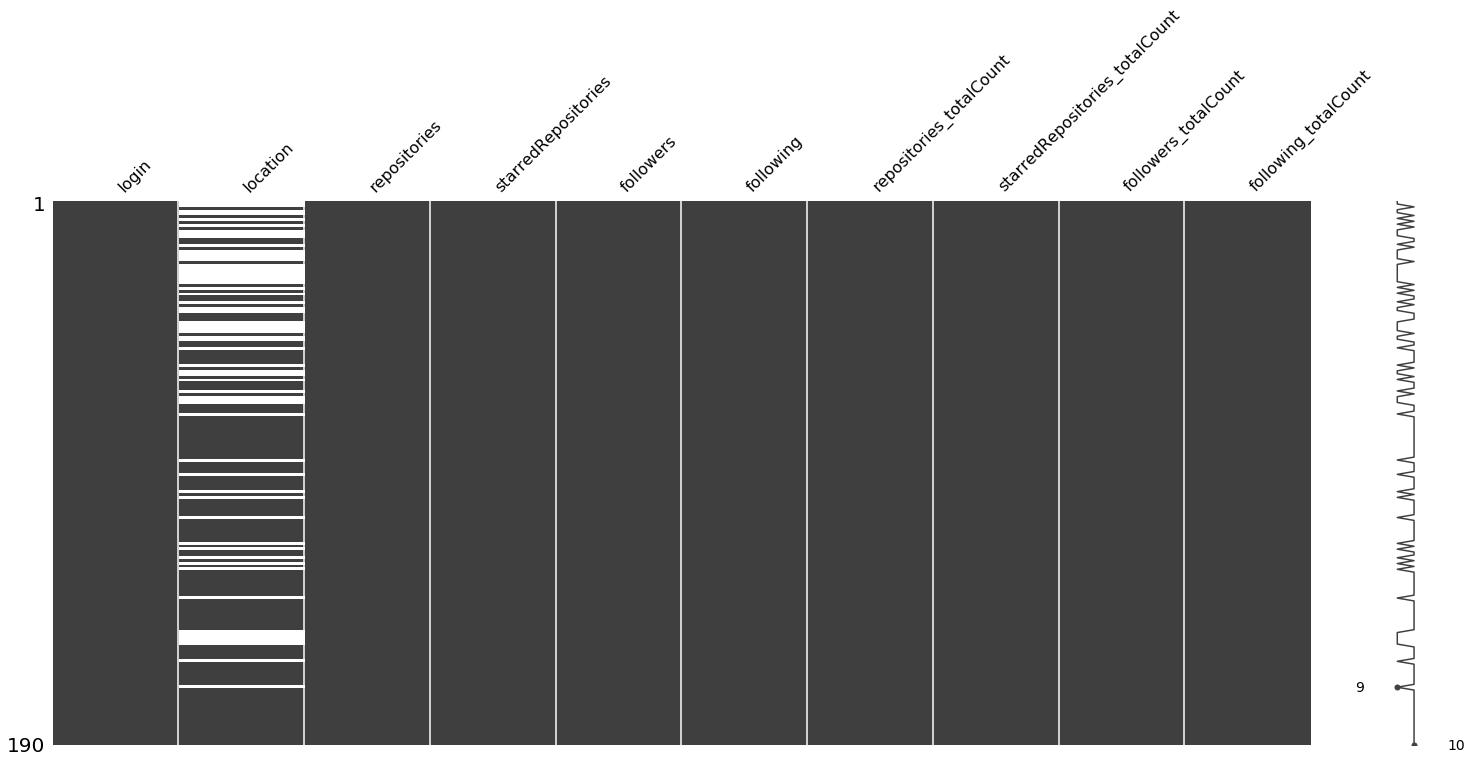

In [17]:
msno.matrix(df_users)

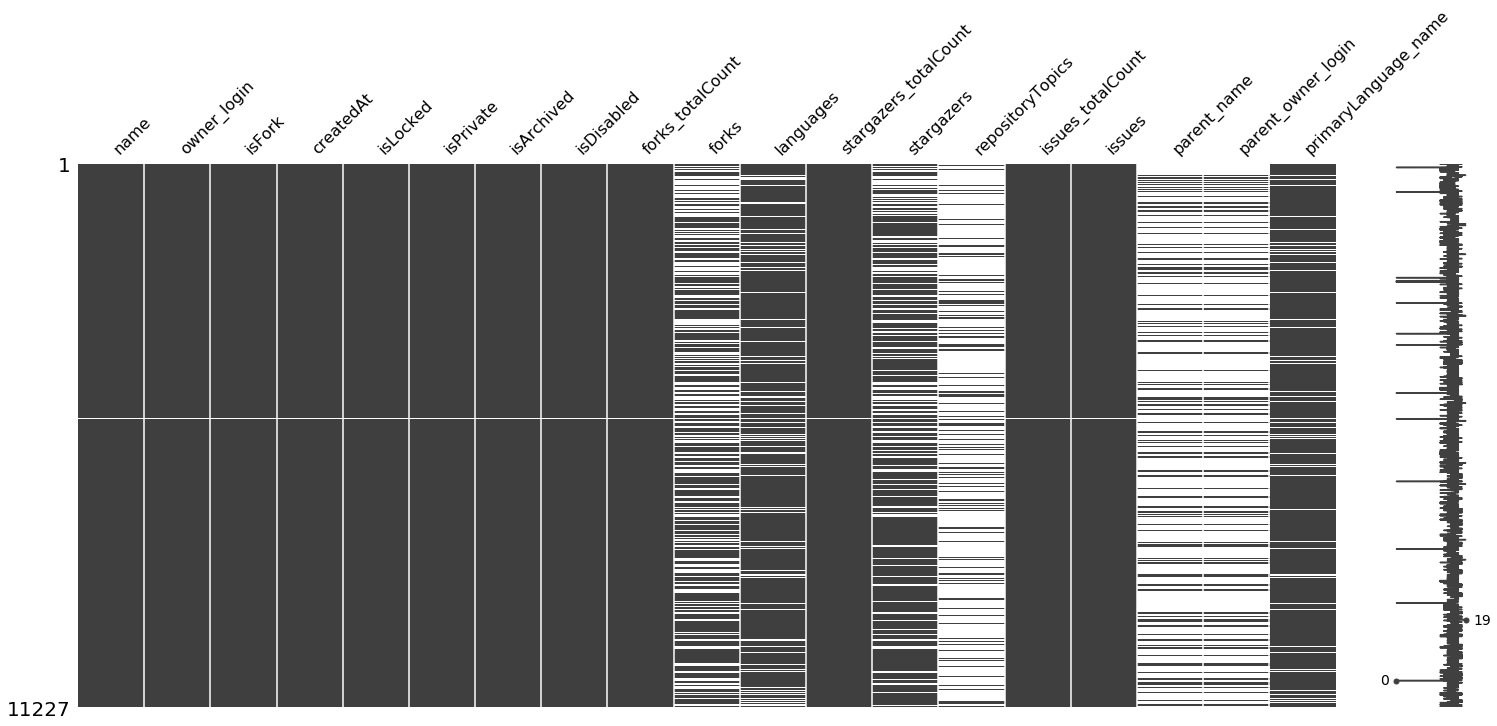

In [18]:
msno.matrix(df_repos_missingno)

# Preparación de los datos

## Filtrado de filas vacías
Filtrar filas con todos los valores NaN. Esto se descubrio porque al hacer unique() vimos que algunas columnas booleanas tambien admitian el valor NaN

In [19]:
df_repos = df_repos[df_repos.notna().any(1)]

## Construcción de datos
Asignamos un campo nuevo para identificar cada user y repositorio

In [20]:
df_users['userId'] = np.arange(len(df_users))
df_repos['repoId'] = np.arange(len(df_repos))

Definimos funciones para finalizar la preparación de los datos:
- Generar lenguajes usados por cada usuario, que sera usada en la siguiente
- Calcular el rating de cada repositorio por usuario

In [21]:
def generate_user_languages(df_users, df_repos):
    """
    Generar diccionario de lenguajes que utilizo cada usuario considerando todos los repositorios que le pertenecen
    """
    results = {}
    
    for _, row in df_users.iterrows():
        user_languages = []
        userId = row['userId']
        for repo in row['repositories']:
            full_repo = df_repos.loc[(df_repos['name'] == repo['name']) & (df_repos['owner_login'] == repo['owner']['login'])]
            for lang_list in full_repo['languages']:
                try:
                    for lang in lang_list:
                        user_languages.append(lang['node']['name'])
                except:
                    pass
        user_language_set = set(user_languages)
        results[userId] = user_language_set
    
    return results

user_languages = generate_user_languages(df_users, df_repos)

In [22]:
def calculate_rating(df_users, df_repos, user_languages):
    """ 
    Algoritmo de calculo de preferencia en base a los atributos del dataset:
        # if isLocked, isArchived, isDisabled: Quitar de la lista
        # if isFork, agregar 1 y mostrar en la app que es fork
        # if forks != NaN: +1
        # if owner in following: +1
        # if any language in user_languages: +1
        # calcular porcentaje de issues abiertos/issue y de ahi asignar puntajes
    """ 
    #crear una lista de dicts de la forma {'userId': x, 'repoId': x, 'rating': x}
    results = []
    paths = ['repositories', 'starredRepositories']
    
    for _, row in df_users.iterrows():
        for path in paths:
            for repo in row[path]:
                try:
                    entry = {}
                    rating = 1
                    entry['userId'] = row['userId']
                    full_repo = df_repos.loc[(df_repos['name'] == repo['name']) & (df_repos['owner_login'] == repo['owner']['login'])].iloc[0]
                    entry['repoId'] = int(full_repo['repoId'])
                except:
                    continue

                if full_repo['isArchived']:
                    continue

                if full_repo['isFork'] or full_repo['forks']:
                    rating += 1

                for following in df_users[df_users['userId'] == row['userId']]['following'].iloc[0]:
                    if full_repo['owner_login'] == following['login']:
                        rating += 1
                        break

                for lang in full_repo['languages']:
                    if lang['node']['name'] in user_languages[row['userId']]:
                        rating += 1
                        break

                closed_issues_count = 0
                issues_count = len(full_repo['issues'])

                for issue in full_repo['issues']:
                    if issue['node']['closed']:
                        closed_issues_count += 1

                if (issues_count > 0) and (closed_issues_count/issues_count > 0.8):
                    rating += 1

                entry['rating'] = rating
                results.append(entry)
                
    return results

ratings = calculate_rating(df_users, df_repos, user_languages)
df_ratings = pd.DataFrame(ratings)

# Modelado y Evaluación
Entrenamos dos algoritmos de recomendación -CoClustering y SVD- usando el paquete surprise 
Evaluamos su performance usando metricas de precision y recall y validación cruzada.

In [23]:
def precision_recall_at_k(predictions, k=10, threshold=2.5):
    '''
    Devolver precisión y recall en las k primeras recomendaciones para cada user.
    Codigo para la función tomado de https://surprise.readthedocs.io/en/stable/FAQ.html
    '''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


reader = Reader()
data = Dataset.load_from_df(df_ratings[['userId', 'repoId', 'rating']], reader)
kf = KFold(n_splits=7)

#Precision & Recall para dos algoritmos diferentes
algo = CoClustering()
prec_total = 0
rec_total = 0
print("CoClustering")
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=2.5)

    prec_at_k = sum(prec for prec in precisions.values()) / len(precisions)
    print(prec_at_k)
    prec_total += prec_at_k
    rec_at_k = sum(rec for rec in recalls.values()) / len(recalls)
    print(rec_at_k)
    rec_total += rec_at_k
print()
print("Promedio de precision: " + str(round(prec_total/7,2)))
print("Promedio de recall: " + str(round(rec_total/7,2)))

print()

algo = SVD()
prec_total = 0
rec_total = 0
print("SVD")
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=2.5)

    prec_at_k = sum(prec for prec in precisions.values()) / len(precisions)
    print(prec_at_k)
    prec_total += prec_at_k
    rec_at_k = sum(rec for rec in recalls.values()) / len(recalls)
    print(rec_at_k)
    rec_total += rec_at_k
print()
print("Promedio de precision: " + str(round(prec_total/7,2)))
print("Promedio de recall: " + str(round(rec_total/7,2)))

CoClustering
0.6767056530214418
0.6479478781377098
0.7165668662674645
0.6409812238757289
0.7237816764132549
0.6488512543337103
0.6961240310077516
0.6647791323663413
0.7138418079096039
0.6865648554207876
0.6999999999999995
0.6310977421271536
0.7210101010101007
0.611281222738442

Promedio de precision: 0.71
Promedio de recall: 0.65

SVD
0.7918650793650789
0.5855739511637066
0.8073412698412693
0.5969088363783741
0.7968441814595655
0.575682676761688
0.8210317460317453
0.5788424621013907
0.8157630522088349
0.581387266269442
0.7749523809523805
0.6089894167457189
0.7896825396825391
0.5905746961198088

Promedio de precision: 0.8
Promedio de recall: 0.59


# Implementación 
## Generación de las primeras n recomendaciones para un usuario


In [24]:
def get_top_n(predictions, n=10):
    '''
    Devolver las top-N recomendaciones para cada usuario en base a una secuencia de predicciones 
    
    Parametros:
    predicciones - Lista de predicciones realizadas por un algoritmo sobre el conjunto de prueba
    n - Cantidad de recomendaciones a hacer
    
    Devuelve:
    Diccionario de {clave: valor} de la forma {usuarioId: (itemId, rating)} 
    '''

    # Mapear las predicciones a cada usuario
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Luego ordenar las predicciones y tomar las k mayores
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# Entrenar un CoClustering con el dataset preparado
reader = Reader()
data = Dataset.load_from_df(df_ratings[['userId', 'repoId', 'rating']], reader)
trainset = data.build_full_trainset()
algo = CoClustering()
algo.fit(trainset)

# Luego predecir los ratings para todos los pares (usuario, item) que no estan en el conjunto de entrenamiento
testset = trainset.build_anti_testset() 
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

In [30]:
# Mostrar las recomendaciones generadas para cada usuario del dataset
for uid, user_ratings in top_n.items():
    print("Usuario",uid, "Top 10 Repositorios:", [iid for (iid, _) in user_ratings])

Usuario 0 Top 10 Repositorios: [1479, 4653, 8338, 897, 2119, 10947, 12, 1098, 1237, 1693]
Usuario 1 Top 10 Repositorios: [12, 897, 1098, 1237, 1479, 1693, 1922, 1959, 2119, 2338]
Usuario 2 Top 10 Repositorios: [1098, 1237, 1693, 1922, 1959, 2338, 3453, 4334, 4416, 4501]
Usuario 3 Top 10 Repositorios: [12, 1098, 1237, 1693, 1922, 1959, 2338, 3453, 4334, 4416]
Usuario 4 Top 10 Repositorios: [12, 1098, 1237, 1693, 1922, 1959, 2338, 3453, 4334, 4416]
Usuario 5 Top 10 Repositorios: [12, 1098, 1237, 1479, 1693, 1922, 1959, 2338, 3453, 4334]
Usuario 6 Top 10 Repositorios: [12, 1098, 1237, 1693, 1922, 1959, 2338, 3453, 4334, 4416]
Usuario 7 Top 10 Repositorios: [12, 1098, 1237, 1693, 1922, 1959, 2338, 3453, 4334, 4416]
Usuario 8 Top 10 Repositorios: [12, 1098, 1237, 1693, 1922, 1959, 2338, 3453, 4334, 4416]
Usuario 9 Top 10 Repositorios: [12, 1098, 1237, 1693, 1922, 1959, 2338, 3453, 4334, 4416]
Usuario 10 Top 10 Repositorios: [897, 1479, 2103, 2119, 3841, 4653, 8338, 10947, 532, 646]
Usuario 

## Tomar los datos de las repositorios recomendados a un usuario para alimentar la aplicación


In [46]:
#Elegir el user ID deseado, por ej. 73, y tomar los repos IDs recomendados a este
recoRepos = top_n[73]

#Tomar los datos de los repos recomendados y presentarlos en una nueva tabla
repoIds = [repoId for repoId, _ in recoRepos]
app_data = df_repos.loc[repoIds, :]

app_data

,name,owner_login,isFork,createdAt,isLocked,isPrivate,isArchived,isDisabled,forks_totalCount,forks,languages,stargazers_totalCount,stargazers,repositoryTopics,issues_totalCount,issues,parent_name,parent_owner_login,primaryLanguage_name,repoId
1479,xml2json.Testcases,zippy1981,False,2011-08-19T14:16:51Z,False,False,False,False,0.0,[],"[{'node': {'name': 'C#'}}, {'node': {'name': '...",1.0,[{'node': {'login': 'zippy1981'}}],[],0.0,[],NaN,NaN,C#,1477
4653,learning-area,DarrenfJ,True,2017-03-26T18:16:32Z,False,False,False,False,0.0,[],"[{'node': {'name': 'HTML'}}, {'node': {'name':...",0.0,[],[],0.0,[],learning-area,mdn,HTML,4637
8338,rust-course,FaztTech,False,2017-04-22T21:32:44Z,False,False,False,False,0.0,[],[{'node': {'name': 'Rust'}}],0.0,[],[],0.0,[],NaN,NaN,Rust,8313
897,zf2-documentation,shevron,True,2012-12-15T07:33:06Z,False,False,False,False,0.0,[],"[{'node': {'name': 'Shell'}}, {'node': {'name'...",0.0,[],[],0.0,[],zf2-documentation,zendframework,Python,895
10947,angularMobile,GoesToEleven,True,2015-06-19T21:04:23Z,False,False,False,False,1.0,"[{'node': {'name': 'angularMobile', 'url': 'ht...","[{'node': {'name': 'JavaScript'}}, {'node': {'...",1.0,[{'node': {'login': 'arifmahmudrana'}}],[],0.0,[],angularMobile,planetoftheweb,JavaScript,10920
12,re,ahx,False,2013-09-28T15:25:28Z,False,False,False,False,1.0,"[{'node': {'name': 're', 'url': 'https://githu...","[{'node': {'name': 'Ruby'}}, {'node': {'name':...",2.0,"[{'node': {'login': 'sbange'}}, {'node': {'log...",[],1.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,Ruby,12
1098,fartscroll.js,theonion,False,2013-04-16T15:23:11Z,False,False,True,False,233.0,"[{'node': {'name': 'fartscroll.js', 'url': 'ht...",[],2742.0,"[{'node': {'login': 'sansb'}}, {'node': {'logi...",[],25.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,NaN,1096
1237,shadowsocks,shadowsocks,False,2012-04-20T13:10:49Z,False,False,False,False,12191.0,"[{'node': {'name': 'shadowsocks', 'url': 'http...","[{'node': {'name': 'Python'}}, {'node': {'name...",30922.0,"[{'node': {'login': 'etng'}}, {'node': {'login...",[],0.0,[],NaN,NaN,Python,1235
1693,create_ap,oblique,False,2013-09-28T05:41:48Z,False,False,False,False,633.0,"[{'node': {'name': 'create_ap', 'url': 'https:...","[{'node': {'name': 'Makefile'}}, {'node': {'na...",3149.0,"[{'node': {'login': 'madduci'}}, {'node': {'lo...","[{'node': {'topic': {'name': 'hostapd', 'relat...",316.0,"[{'node': {'state': 'OPEN', 'closed': False, '...",NaN,NaN,Shell,1691
1922,weirdAAL,carnal0wnage,False,2017-05-31T14:50:32Z,False,False,False,False,38.0,"[{'node': {'name': 'weirdAAL', 'url': 'https:/...",[{'node': {'name': 'Python'}}],328.0,"[{'node': {'login': 'epinna'}}, {'node': {'log...","[{'node': {'topic': {'name': 'python3', 'relat...",45.0,"[{'node': {'state': 'CLOSED', 'closed': True, ...",NaN,NaN,Python,1920
